In [1]:
import sys

In [2]:
!{sys.executable} -m pip install -r ../requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

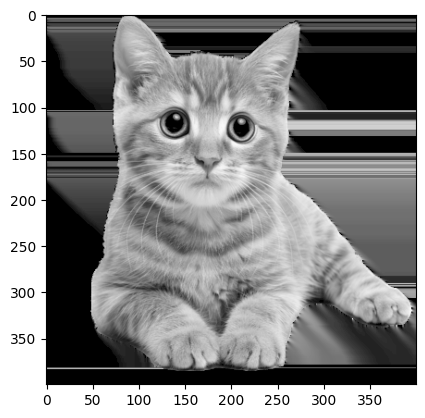

In [4]:
img = cv2.imread("../cat.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [9]:
# Scale-Invariant Feature Transform (SIFT)

# Step 1: To detect blobs at multiple sizes, we create a scale-space
def build_dog_pyramid(image, num_scales=5, sigma=1.6, k=np.sqrt(2)):
    gaussians = []
    dogs = []

    for i in range(num_scales + 1):
        sigma_i = sigma * (k ** i)
        blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_i)
        gaussians.append(blurred)

    for i in range(num_scales):
        dogs.append(gaussians[i+1] - gaussians[i])

    return np.stack(dogs, axis=-1)


# Step 2: Keypoint localization (refine the position by fitting a 3D quadratic to estimate subpixel peak)
# Keypoint detection: Check each pixel in 3D DoG (x, y, scale) for local extrema (26 neighbors)
def is_extremum(D, x, y, s):
    patch = D[x-1:x+2, y-1:y+2, s-1:s+2]
    center = D[x, y, s]
    return (center == patch.max()) or (center == patch.min())

# use central differences for gradient approximation
def compute_gradient(D, x, y, s):
    dx = (D[x+1, y, s] - D[x-1, y, s]) / 2.0
    dy = (D[x, y+1, s] - D[x, y-1, s]) / 2.0
    ds = (D[x, y, s+1] - D[x, y, s-1]) / 2.0
    return np.array([dx, dy, ds])

def compute_hessian(D, x, y, s):
    dxx = D[x+1, y, s] - 2 * D[x, y, s] + D[x-1, y, s]
    dyy = D[x, y+1, s] - 2 * D[x, y, s] + D[x, y-1, s]
    dss = D[x, y, s+1] - 2 * D[x, y, s] + D[x, y, s-1]

    dxy = (D[x+1, y+1, s] - D[x+1, y-1, s] - D[x-1, y+1, s] + D[x-1, y-1, s]) / 4.0
    dxs = (D[x+1, y, s+1] - D[x+1, y, s-1] - D[x-1, y, s+1] + D[x-1, y, s-1]) / 4.0
    dys = (D[x, y+1, s+1] - D[x, y+1, s-1] - D[x, y-1, s+1] + D[x, y-1, s-1]) / 4.0

    return np.array([
        [dxx, dxy, dxs],
        [dxy, dyy, dys],
        [dxs, dys, dss]
    ])

# fit 3D quadratic and find offset by solving x_hat = −H^−1 * ∇D
def localize_keypoint(D, x, y, s):
    grad = compute_gradient(D, x, y, s)
    H = compute_hessian(D, x, y, s)

    try:
        offset = -np.linalg.inv(H).dot(grad)
    except np.linalg.LinAlgError:
        return None  # ill-conditioned Hessian

    return offset  # (dx, dy, ds)

# Discard Low-Contrast Keypoints and Interpolate contrast using: D(x_hat) = D + (1/2) * (∇D^T) * x_hat
def interpolate_contrast(D, x, y, s, offset):
    D_val = D[x, y, s]
    grad = compute_gradient(D, x, y, s)
    contrast = D_val + 0.5 * grad.dot(offset)
    return contrast

# Edge Rejection via Hessian Score
# Take the 2D spatial Hessian (top-left 2x2 of full Hessian):
# H = [Dxx Dxy]
#     [Dxy Dyy]
# Use:
# edge_score = (TrH)^2 / detH
# If score > (r+1)^2 / r, discard. Use r=10 → threshold ≈ 12.1
def edge_response(H_spatial, r=10):
    tr = np.trace(H_spatial)
    det = np.linalg.det(H_spatial)
    if det <= 0:
        return float('inf')
    return (tr ** 2) / det

# final keypoint refinement function to localize keypoint, discard low contrast points, and reject edges
def refine_keypoint(D, x, y, s, contrast_thresh=0.03, edge_thresh=10):
    offset = localize_keypoint(D, x, y, s)
    if offset is None or np.any(np.abs(offset) > 1):
        return None

    contrast = interpolate_contrast(D, x, y, s, offset)
    if abs(contrast) < contrast_thresh:
        return None

    H = compute_hessian(D, x, y, s)
    H_spatial = H[:2, :2]
    edge_score = edge_response(H_spatial, edge_thresh)
    if edge_score > ((edge_thresh + 1) ** 2) / edge_thresh:
        return None

    return (x + offset[0], y + offset[1], s + offset[2])


# Step 3: Orientation assignment with 36 bins over 360 degrees
def compute_gradients(patch):
    gx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)
    magnitude = np.sqrt(gx**2 + gy**2)
    angle = (np.arctan2(gy, gx) * 180 / np.pi) % 360
    return magnitude, angle

def assign_orientation(image, x, y, radius=8, sigma=1.5):
    H, W = image.shape
    x, y = int(round(x)), int(round(y))
    
    # Extract patch
    x0, x1 = max(0, x - radius), min(H, x + radius + 1)
    y0, y1 = max(0, y - radius), min(W, y + radius + 1)
    patch = image[x0:x1, y0:y1]

    # Gaussian weights centered in patch
    cx, cy = (x1 - x0) // 2, (y1 - y0) // 2
    xv, yv = np.meshgrid(np.arange(y1 - y0), np.arange(x1 - x0))
    gauss = np.exp(-((xv - cy)**2 + (yv - cx)**2) / (2 * sigma**2))

    # Gradient and angle
    mag, angle = compute_gradients(patch)
    weighted_mag = mag * gauss

    # Orientation histogram
    hist, _ = np.histogram(angle, bins=36, range=(0, 360), weights=weighted_mag)
    dominant_angle = np.argmax(hist) * 10  # Each bin = 10 degrees

    return dominant_angle

def rotate_patch(image, x, y, angle_deg, size=16):
    angle_rad = -np.deg2rad(angle_deg)  # negative for correct rotation
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    patch = np.zeros((size, size), dtype=np.float32)
    half = size // 2

    for i in range(size):
        for j in range(size):
            xi = int(x + (i - half) * cos_a - (j - half) * sin_a)
            yj = int(y + (i - half) * sin_a + (j - half) * cos_a)

            if 0 <= xi < image.shape[0] and 0 <= yj < image.shape[1]:
                patch[i, j] = image[xi, yj]

    return patch


# Step 4: Final descriptor constructor
# Take a rotated 16×16 patch around keypoint
# Divide into 4x4 blocks
# Each block → 8-bin gradient orientation histogram
# Final descriptor: 4x4x8=128 vector
# Generate the Difference of Gaussian (DoG) pyramid
def compute_sift_descriptor(image, x, y, angle, window_size=16, cell_size=4, bins=8):
    patch = rotate_patch(image, x, y, angle, size=window_size)
    gx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)

    mag = np.sqrt(gx**2 + gy**2)
    ori = (np.arctan2(gy, gx) * 180 / np.pi - angle) % 360  # relative to keypoint

    descriptor = []

    for i in range(0, window_size, cell_size):
        for j in range(0, window_size, cell_size):
            cell_mag = mag[i:i+cell_size, j:j+cell_size]
            cell_ori = ori[i:i+cell_size, j:j+cell_size]

            hist = np.zeros(bins)
            for m in range(cell_mag.shape[0]):
                for n in range(cell_mag.shape[1]):
                    bin_idx = int(cell_ori[m, n] * bins / 360.0) % bins
                    hist[bin_idx] += cell_mag[m, n]

            descriptor.extend(hist)

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor) + 1e-7
    descriptor = descriptor / norm

    # Clip and renormalize (SIFT robustness trick)
    descriptor = np.clip(descriptor, 0, 0.2)
    descriptor /= (np.linalg.norm(descriptor) + 1e-7)

    return descriptor

In [11]:
img = cv2.resize(img, (256, 256))

D = build_dog_pyramid(img, num_scales=5)

refined_kps = []
H, W, S = D.shape

for s in range(1, S-1):
    for x in range(1, H-1):
        for y in range(1, W-1):
            if is_extremum(D, x, y, s):
                kp = refine_keypoint(D, x, y, s)
                if kp is not None:
                    refined_kps.append(kp)

sift_kps = []
for x, y, s in refined_kps:
    sigma = 1.6 * (np.sqrt(2) ** s)
    blurred = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma)
    angle = assign_orientation(blurred, x, y)
    sift_kps.append((x, y, s, angle))

keypoints = []
for x, y, s, angle in sift_kps:
    sigma = 1.6 * (np.sqrt(2) ** s)
    blurred = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma)
    descriptor = compute_sift_descriptor(blurred, x, y, angle)

    keypoints.append({
        'x': x,
        'y': y,
        'scale': s,
        'angle': angle,
        'descriptor': descriptor
    })

vis_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
for kp in keypoints:
    x, y, angle = int(kp['x']), int(kp['y']), kp['angle']
    end_x = int(x + 5 * np.cos(np.deg2rad(angle)))
    end_y = int(y + 5 * np.sin(np.deg2rad(angle)))
    cv2.circle(vis_img, (x, y), 2, (0, 255, 0), -1)
    cv2.line(vis_img, (x, y), (end_x, end_y), (0, 255, 0), 1)

cv2.imshow("SIFT Keypoints", vis_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/1193382915.py:35: RuntimeWarning: overflow encountered in scalar add
  dyy = D[x, y+1, s] - 2 * D[x, y, s] + D[x, y-1, s]
/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/1193382915.py:36: RuntimeWarning: overflow encountered in scalar add
  dss = D[x, y, s+1] - 2 * D[x, y, s] + D[x, y, s-1]
/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/1193382915.py:38: RuntimeWarning: overflow encountered in scalar subtract
  dxy = (D[x+1, y+1, s] - D[x+1, y-1, s] - D[x-1, y+1, s] + D[x-1, y-1, s]) / 4.0
/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/1193382915.py:38: RuntimeWarning: overflow encountered in scalar add
  dxy = (D[x+1, y+1, s] - D[x+1, y-1, s] - D[x-1, y+1, s] + D[x-1, y-1, s]) / 4.0
/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/1193382915.py:39: RuntimeWarning: overflow encountered in scalar subtract
  dxs = (D[x+1, y, s+1] - D[x+1, y, s-1] - D[x-1, 

In [ ]:
# Oriented FAST keypoints + Rotated BRIEF descriptors (ORB)

# Part 1: FAST = Features from Accelerated Segment Test
def fast_keypoints(img, threshold=20, N=12, radius=3):
    circle_idx = [
        (0, -radius), (radius // 2, -radius), (radius, -radius // 2), (radius, 0),
        (radius, radius // 2), (radius // 2, radius), (0, radius), (-radius // 2, radius),
        (-radius, radius // 2), (-radius, 0), (-radius, -radius // 2), (-radius // 2, -radius)
    ]
    H, W = img.shape
    keypoints = []

    for y in range(radius, H - radius):
        for x in range(radius, W - radius):
            p = img[y, x]
            brighter = 0
            darker = 0
            for dx, dy in circle_idx:
                val = img[y + dy, x + dx]
                if val > p + threshold:
                    brighter += 1
                elif val < p - threshold:
                    darker += 1
            if brighter >= N or darker >= N:
                keypoints.append((x, y))
    return keypoints

# Part 2: Intensity centroid. Use the first moment (center of mass) of the image patch around the keypoint:
# m10 = ∑x I(x, y), m01 = ∑y I(x, y). Then, θ = arctan2(m01, m10)
def compute_orientation(img, x, y, patch_size=31):
    r = patch_size // 2
    x0, x1 = x - r, x + r + 1
    y0, y1 = y - r, y + r + 1

    if x0 < 0 or y0 < 0 or x1 > img.shape[1] or y1 > img.shape[0]:
        return None

    patch = img[y0:y1, x0:x1]
    cy, cx = np.mgrid[-r:r+1, -r:r+1]
    m10 = np.sum(cx * patch)
    m01 = np.sum(cy * patch)
    angle = np.arctan2(m01, m10)
    return angle  # radians


# Part 3: BRIEF = Binary Robust Independent Elementary Features
# Random BRIEF Pattern Generator
def generate_brief_pairs(n=256, patch_size=31):
    coords = np.random.randint(-patch_size // 2, patch_size // 2, size=(n, 2, 2))
    return coords

# BRIEF Descriptor (Rotated)
def rotate_point(x, y, angle):
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    xr = cos_a * x - sin_a * y
    yr = sin_a * x + cos_a * y
    return int(round(xr)), int(round(yr))

def compute_brief_descriptor(img, x, y, angle, pairs, patch_size=31):
    r = patch_size // 2
    desc = []
    H, W = img.shape

    for (p1, p2) in pairs:
        dx1, dy1 = rotate_point(p1[0], p1[1], angle)
        dx2, dy2 = rotate_point(p2[0], p2[1], angle)

        x1, y1 = x + dx1, y + dy1
        x2, y2 = x + dx2, y + dy2

        if not (0 <= x1 < W and 0 <= y1 < H and 0 <= x2 < W and 0 <= y2 < H):
            desc.append(0)
        else:
            desc.append(1 if img[y1, x1] < img[y2, x2] else 0)

    return np.array(desc, dtype=np.uint8)

# Final ORB pipeline
def orb_pipeline(img, brief_len=256):
    img = cv2.GaussianBlur(img, (3, 3), 0)
    keypoints_xy = fast_keypoints(img)
    pairs = generate_brief_pairs(n=brief_len)
    orb_features = []

    for (x, y) in keypoints_xy:
        angle = compute_orientation(img, x, y)
        if angle is None:
            continue
        desc = compute_brief_descriptor(img, x, y, angle, pairs)
        orb_features.append({
            'x': x,
            'y': y,
            'angle': angle,
            'descriptor': desc
        })

    return orb_features

# Visualize keypoints
def draw_orb_keypoints(img, features):
    vis = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    for kp in features:
        x, y, a = kp['x'], kp['y'], kp['angle']
        end_x = int(x + 5 * np.cos(a))
        end_y = int(y + 5 * np.sin(a))
        cv2.circle(vis, (x, y), 2, (0, 255, 0), -1)
        cv2.line(vis, (x, y), (end_x, end_y), (0, 255, 0), 1)
    return vis

def hamming_distance(desc1, desc2):
    return np.count_nonzero(desc1 != desc2)

def match_descriptors(features1, features2, max_dist=30):
    matches = []
    for i, f1 in enumerate(features1):
        best_match = None
        best_score = float('inf')
        for j, f2 in enumerate(features2):
            d = hamming_distance(f1['descriptor'], f2['descriptor'])
            if d < best_score:
                best_score = d
                best_match = (i, j)
        if best_score < max_dist:
            matches.append(best_match)
    return matches

def draw_matches(img1, features1, img2, features2, matches):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2
    canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)

    for i, j in matches:
        x1, y1 = features1[i]['x'], features1[i]['y']
        x2, y2 = features2[j]['x'], features2[j]['y']
        cv2.circle(canvas, (x1, y1), 2, (0, 255, 0), -1)
        cv2.circle(canvas, (x2 + w1, y2), 2, (0, 255, 0), -1)
        cv2.line(canvas, (x1, y1), (x2 + w1, y2), (255, 0, 0), 1)

    return canvas

/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/2783592960.py:22: RuntimeWarning: overflow encountered in scalar subtract
  elif val < p - threshold:
/var/folders/l_/pykbbq2j777fxwk23__0mbpc0000gq/T/ipykernel_14183/2783592960.py:20: RuntimeWarning: overflow encountered in scalar add
  if val > p + threshold:


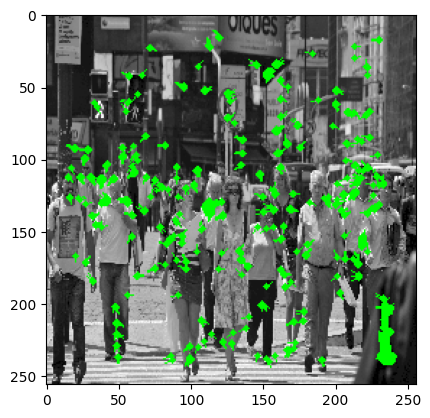

In [22]:
img = cv2.resize(cv2.imread("../pedestrians.png", cv2.IMREAD_GRAYSCALE), (256, 256))
features = orb_pipeline(img)
vis = draw_orb_keypoints(img, features)

plt.imshow(vis)